In [3]:
# this makes the notebook expand to full width of the browser window
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [4]:
%%javascript

// turn off scrollable windows for too large output
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [5]:
import os, sys

import pandas as pd
import numpy as np
import gzip
import cloudpickle
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier

root_path = root_path = os.path.realpath('../..')

# set this path to differ by project
data_dir = os.path.realpath(os.path.join(root_path, "auto-causality/data/example"))

parent = os.path.realpath(os.path.join(data_dir, ".."))
if not os.path.isdir(parent):
    os.mkdir(parent)
if not os.path.isdir(data_dir):
    os.mkdir(data_dir)
print(data_dir)

C:\Users\egor.kraev\Transferwise\auto-causality\data\example


In [6]:
# run this cell if you are using dowhy and this repo by just pulling the source
sys.path.append(os.path.join(root_path, "dowhy"))
sys.path.append(os.path.join(root_path, "auto-causality"))

In [7]:
from dowhy import CausalModel

from auto_causality.utils import featurize, AutoMLWrapper
from auto_causality.params import SimpleParamService
from auto_causality.scoring import make_scores, ate, group_ate

In [6]:
# load raw data
data= pd.read_csv("https://raw.githubusercontent.com/AMLab-Amsterdam/CEVAE/master/datasets/IHDP/csv/ihdp_npci_1.csv", header = None)
col =  ["treatment", "y_factual", "y_cfactual", "mu0", "mu1" ,]
for i in range(1,26):
    col.append("x"+str(i))
data.columns = col

display(data.dtypes)
data.head()

treatment       int64
y_factual     float64
y_cfactual    float64
mu0           float64
mu1           float64
x1            float64
x2            float64
x3            float64
x4            float64
x5            float64
x6            float64
x7              int64
x8              int64
x9              int64
x10             int64
x11             int64
x12             int64
x13             int64
x14             int64
x15             int64
x16             int64
x17             int64
x18             int64
x19             int64
x20             int64
x21             int64
x22             int64
x23             int64
x24             int64
x25             int64
dtype: object

,treatment,y_factual,y_cfactual,mu0,mu1,x1,x2,x3,x4,x5,...,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25
0,1,5.599916,4.318780,3.268256,6.854457,-0.528603,-0.343455,1.128554,0.161703,-0.316603,...,1,1,1,1,0,0,0,0,0,0
1,0,6.875856,7.856495,6.636059,7.562718,-1.736945,-1.802002,0.383828,2.244320,-0.629189,...,1,1,1,1,0,0,0,0,0,0
2,0,2.996273,6.633952,1.570536,6.121617,-0.807451,-0.202946,-0.360898,-0.879606,0.808706,...,1,0,1,1,0,0,0,0,0,0
3,0,1.366206,5.697239,1.244738,5.889125,0.390083,0.596582,-1.850350,-0.879606,-0.004017,...,1,0,1,1,0,0,0,0,0,0
4,0,1.963538,6.202582,1.685048,6.191994,-1.045229,-0.602710,0.011465,0.161703,0.683672,...,1,1,1,1,0,0,0,0,0,0


In [7]:
# drop the columns we don't care about
ignore_patterns = ['y_cfactual','mu']
ignore_cols = [c for c in data.columns if any([s in c for s in ignore_patterns])]
data = data.drop(columns=ignore_cols)

In [8]:
# set all the control parameters here
train_size = 0.5
test_size = None
time_budget = 60
num_cores = os.cpu_count() -4
conf_intervals=False

# Only change the n_bootstrap_samples (to at least 20) if you want
# confidence intervals specifically for metalearner models
# warning: that will be VERY slow!
n_bootstrap_samples = None

In [9]:
# prepare the data

treatment = "treatment"
targets = ["y_factual"] # it's good to allow multiple ones
features = [c for c in data.columns if c not in [treatment] + targets]

data[treatment] = data[treatment].astype(int)
# this is a trick to bypass some DoWhy/EconML bugs
data["random"] = np.random.randint(0, 2, size=len(data))

used_df = featurize(
        data,
        features=features,
        exclude_cols=[treatment] + targets,
        drop_first=False,
    )
used_features = [
        c for c in used_df.columns if c not in ignore_cols + [treatment] + targets
    ]


# Let's treat all features as effect modifiers
features_X = [f for f in used_features if f != "random"]
features_W = [f for f in used_features if f not in features_X]

In [10]:
if not (os.path.isfile(os.path.join(data_dir, f"test_{time_budget}.csv")) and
        os.path.isfile(os.path.join(data_dir, f"train_{time_budget}.csv"))):
    train_df, test_df = train_test_split(used_df, train_size=train_size)
    if test_size is not None:
        test_df = test_df.sample(test_size)
    test_df.to_csv(os.path.join(data_dir, f"test_{time_budget}.csv"))
    train_df.to_csv(os.path.join(data_dir, f"train_{time_budget}.csv"))
else:
    test_df = pd.read_csv(os.path.join(data_dir, f"test_{time_budget}.csv"))
    train_df = pd.read_csv(os.path.join(data_dir, f"train_{time_budget}.csv"))
        
del data

In [11]:
# define model parametrization
propensity_model = DummyClassifier(strategy="prior")
outcome_model = AutoMLWrapper(
    fit_params={
        "time_budget": time_budget,
        "verbose": 1,
        "task": "regression",
        "n_jobs": num_cores,
        "pred_time_limit": 10 / 1e6,
    }
)

cfg = SimpleParamService(
    propensity_model,
    outcome_model,
    n_bootstrap_samples=n_bootstrap_samples,
    min_leaf_size=2*len(used_features)
)

In [12]:
# and now let's fit some models!

for outcome in targets:  
    print(outcome)
    model = CausalModel(
        data=train_df,
        treatment=treatment,
        outcome=outcome,
        common_causes=features_W,
        effect_modifiers=features_X,
    )
    identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
    
    estimates = {}
    eis ={}
    for estimator in cfg.estimators():
        if not any(
            [
                e in estimator
                for e in [
                    "causality",
                    "metalearners",
                    "CausalForestDML",
                    ".LinearDML",
                    "SparseLinearDML",
                    "ForestDRLearner",
                    "LinearDRLearner",
                    "Ortho"
                ]
            ]
        ):  
            continue
            
        scores_fname = os.path.join(data_dir, f"scores_{estimator}_{outcome}_{time_budget}.zip")
        model_fname = os.path.join(data_dir, f"model_{estimator}_{outcome}_{time_budget}.zip")
        if os.path.isfile(scores_fname) and os.path.isfile(model_fname):
            continue

        method_params = cfg.method_params(estimator)
        print("fitting", estimator, method_params)

        estimates[estimator] = model.estimate_effect(
            identified_estimand,
            method_name=estimator,
            control_value=0,
            treatment_value=1,
            target_units="ate",  # condition used for CATE
            confidence_intervals=conf_intervals,
            method_params=method_params,
        )

        estimates[estimator].interpret()

        if conf_intervals:
            X_train = train_df[estimates[estimator].estimator._effect_modifier_names]
            est_obj = estimates[estimator].estimator.estimator
            eis[estimator] = est_obj.effect_inference(X_train)
            print(eis[estimator].population_summary())
        else:
            eis[estimator] = None

        try:
            te_train = estimates[estimator].cate_estimates
            X_test = test_df[estimates[estimator].estimator._effect_modifier_names] 
            te_test = estimates[estimator].estimator.estimator.effect(X_test).flatten()
            print(
                "manual mean impact:",
                te_train.mean(),
                te_test.mean(),
                "std:",
                te_train.std()/np.sqrt(len(te_train)),
            )
        except:
            te_train = estimates[estimator].estimator.effect(train_df)
            te_test = estimates[estimator].estimator.effect(test_df)

        scores = {
            "estimator": estimator,
            "outcome": outcome,
            "train": make_scores(estimates[estimator], train_df, te_train),
            "test": make_scores(estimates[estimator], test_df, te_test),
        }

        print(
            f"Scores for {estimator}_{outcome}",
            scores["train"]["erupt"],
            scores["test"]["erupt"],
        )

        print("dumping...")

        with gzip.open(scores_fname, "wb") as f:
            cloudpickle.dump(scores, f)
            
        with gzip.open(model_fname, "wb") as f:
            cloudpickle.dump(estimates[estimator], f)

        print("yahoo!")

y_factual
fitting backdoor.econml.dr.LinearDRLearner {'init_params': {'model_propensity': DummyClassifier(), 'model_regression': <auto_causality.utils.AutoMLWrapper object at 0x0000022E984D25E0>}, 'fit_params': {}}
calling AutoML fit method with  {'time_budget': 60, 'verbose': 1, 'task': 'regression', 'n_jobs': 8, 'pred_time_limit': 1e-05}
calling AutoML fit method with  {'time_budget': 60, 'verbose': 1, 'task': 'regression', 'n_jobs': 8, 'pred_time_limit': 1e-05}
Increasing the treatment variable(s) [treatment] from [0] to [1] causes an increase of 3.8122928140530905 in the expected value of the outcome [y_factual], over the data distribution/population represented by the dataset.
manual mean impact: 3.8122928140530905 3.803564916575098 std: 0.04465948186705196
Scores for backdoor.econml.dr.LinearDRLearner_y_factual 6.318419841333325 6.566009170312499
dumping...
yahoo!
fitting backdoor.econml.dr.SparseLinearDRLearner {'init_params': {'model_propensity': DummyClassifier(), 'model_regre

Not implemented yet...
manual mean impact: 3.890108227048098 3.825164402468139 std: 0.11349092003298815
Scores for backdoor.auto_causality.dowhy_wrapper.direct_uplift.DirectUpliftDoWhyWrapper_y_factual 6.313505869492794 6.505752117213852
dumping...
yahoo!
fitting backdoor.econml.orf.DROrthoForest {'init_params': {'propensity_model': DummyClassifier(), 'model_Y': Ridge(alpha=0.01), 'n_jobs': None, 'max_depth': 10, 'n_trees': 500, 'min_leaf_size': 52, 'backend': 'threading'}, 'fit_params': {}}


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 373 out of 373 | elapsed:    7.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concur

Increasing the treatment variable(s) [treatment] from [0] to [1] causes an increase of 3.879683860475794 in the expected value of the outcome [y_factual], over the data distribution/population represented by the dataset.


[Parallel(n_jobs=1)]: Done 374 out of 374 | elapsed:    6.1s finished


manual mean impact: 3.879683860475794 3.8892487939502365 std: 0.03971064314991423
Scores for backdoor.econml.orf.DROrthoForest_y_factual 6.318419841333325 6.566009170312499
dumping...
yahoo!
fitting backdoor.econml.orf.DMLOrthoForest {'init_params': {'model_T': DummyClassifier(), 'model_Y': Ridge(alpha=0.01), 'discrete_treatment': True, 'n_jobs': None, 'max_depth': 10, 'n_trees': 500, 'min_leaf_size': 52, 'backend': 'threading'}, 'fit_params': {}}


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 373 out of 373 | elapsed:    5.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concur

Increasing the treatment variable(s) [treatment] from [0] to [1] causes an increase of 3.4295745164790343 in the expected value of the outcome [y_factual], over the data distribution/population represented by the dataset.


[Parallel(n_jobs=1)]: Done 374 out of 374 | elapsed:    5.4s finished


manual mean impact: 3.4295745164790343 3.441741646046231 std: 0.057799868900670556
Scores for backdoor.econml.orf.DMLOrthoForest_y_factual 6.3198547769810425 6.572709809635602
dumping...
yahoo!


In [14]:
import glob
from collections import defaultdict

# add a baseline calculation
train_df = pd.read_csv(os.path.join(data_dir, f"train_{time_budget}.csv"))
test_df = pd.read_csv(os.path.join(data_dir, f"test_{time_budget}.csv"))

scores = defaultdict(lambda:defaultdict(dict))
for outcome in targets:
    scores[outcome]["baseline"]={"estimator": "baseline",
                               "outcome": outcome,
                              "train":{"erupt": train_df[outcome].mean(),
                                       "ate": ate(train_df[treatment],train_df[outcome])[0]},
                              "test":{"erupt": test_df[outcome].mean(),
                                      "ate": ate(test_df[treatment],test_df[outcome])[0]}}
                              
                              


In [16]:
for outcome in targets:
    print(outcome)
    for estimator in cfg.estimators():
        try:
            fname = os.path.join(data_dir, f"scores_{estimator}_*_{time_budget}.zip")
            files = glob.glob(fname)
            if not len(files):
                continue
            with gzip.open(files[0], "rb") as f:
                scores[outcome][estimator] = cloudpickle.load(f)
                print(estimator, "score:", scores[outcome][estimator])
        except Exception as e:
            display(e)
            continue

y_factual
backdoor.econml.metalearners.SLearner score: {'estimator': 'backdoor.econml.metalearners.SLearner', 'outcome': 'y_factual', 'train': {'erupt': 6.3417664885438505, 'ate': 3.633068245496133, 'intrp': <econml.cate_interpreter._interpreters.SingleTreeCateInterpreter object at 0x0000022E98459FA0>, 'values':      treated  y_factual         p  policy   weights
0        0.0   2.423223  0.201072    True  0.000000
1        0.0   1.910124  0.201072    True  0.000000
2        0.0   1.205501  0.201072    True  0.000000
3        0.0   2.264436  0.201072    True  0.000000
4        1.0   5.926609  0.201072    True  4.875175
..       ...        ...       ...     ...       ...
368      0.0   1.667935  0.201072    True  0.000000
369      0.0  -0.044151  0.201072    True  0.000000
370      0.0   1.299076  0.201072    True  0.000000
371      0.0   3.890765  0.201072    True  0.000000
372      0.0   4.230410  0.201072    True  0.000000

[373 rows x 5 columns]}, 'test': {'erupt': 6.54231262479154, 

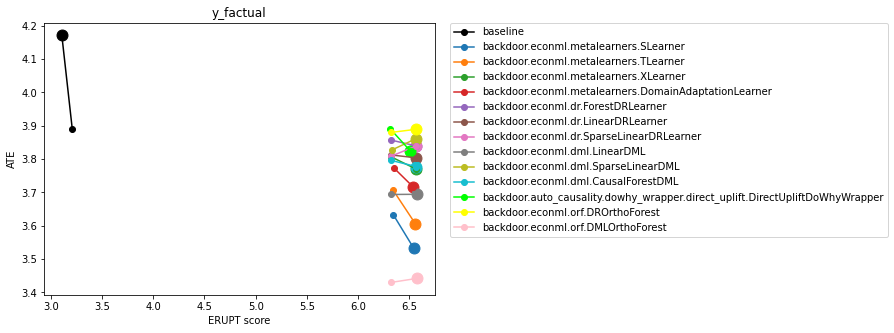

In [17]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

colors = ([matplotlib.colors.CSS4_COLORS['black']] +
    list(matplotlib.colors.TABLEAU_COLORS) + [
    matplotlib.colors.CSS4_COLORS['lime'],
    matplotlib.colors.CSS4_COLORS['yellow'],
    matplotlib.colors.CSS4_COLORS['pink']
])

for outcome, v in scores.items():
    plt.figure(figsize = (7,5))
    plt.title(outcome)
    for (est, scr),col in zip(v.items(),colors):
        sc = [scr['train']['erupt'], scr['test']['erupt']]
        crv = [scr['train']['ate'], scr['test']['ate']]
        plt.plot(sc, crv, color=col, marker="o")
        plt.scatter(sc[1:],crv[1:], c=col, s=120 )
        plt.grid()
        plt.xlabel("ERUPT score")
        plt.ylabel("ATE")
        plt.legend(v.keys(),bbox_to_anchor=(1.04,1), borderaxespad=0)
        
    
    plt.show()



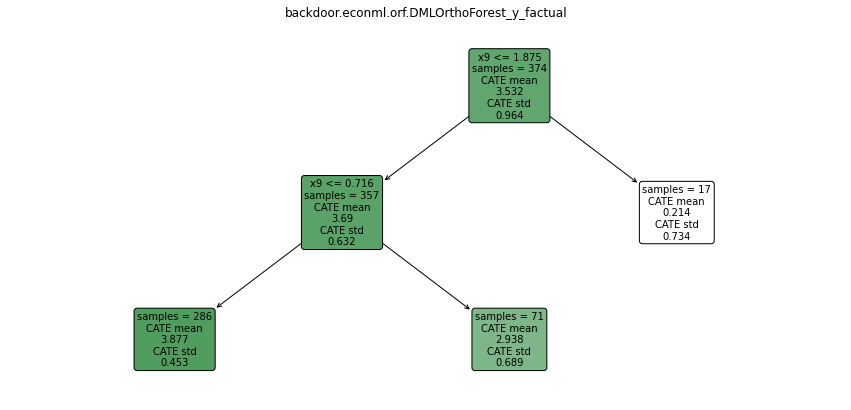

In [18]:
for outcome, v in scores.items():
    for est, scr in v.items():
        if est == 'baseline':
            continue
        intrp = scr['test']['intrp']
        plt.figure(figsize=(15, 7))
        try: 
            feature_names = intrp.feature_names
        except:
            feature_names = features_X + [ w for w in features_W if w not in features_X]
        intrp.plot(feature_names=intrp.feature_names, fontsize=10)
#         intrp.plot( fontsize=10)
        plt.title(f"{estimator}_{outcome}")
        plt.show()
        # remove the 'break' if you want to see all simple policies
        break

In [19]:
import cloudpickle
def load_model(data_dir: str, estimator:str, outcome: str, time_budget:str):
    new_fn = os.path.join(data_dir, f"model_{estimator}_{outcome}_{time_budget}.zip")
    print('loading', new_fn)
    with gzip.open(new_fn, "rb") as f:
        model = cloudpickle.load(f)
        return model


y_factual backdoor.econml.dml.CausalForestDML
loading C:\Users\egor.kraev\Transferwise\auto-causality\data\example\model_backdoor.econml.dml.CausalForestDML_y_factual_60.zip



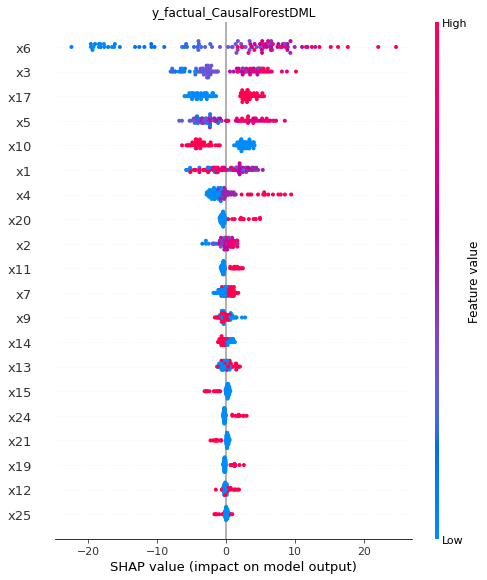

In [20]:
# TODO: add SHAP plots!
import matplotlib.pyplot as plt
import shap

# and now let's visualize feature importances!
from auto_causality.shap import shap_values

# Shapley values calculation can be slow so let's subsample
this_df = test_df.sample(100)

wanted = ["CausalForestDML"]#,"ForestDRLearner","DirectUpliftDoWhyWrapper"]#,"CausalForestDML",]

for outcome, v in scores.items():
    for estimator, scr in v.items():
        if not any([e in estimator for e in wanted]):
            continue
        print(outcome, estimator)
        est = load_model(data_dir, estimator, outcome, time_budget)
        shaps = shap_values(est, this_df)

        plt.title(outcome + '_' + estimator.split('.')[-1])
        shap.summary_plot(shaps, this_df[est.estimator._effect_modifier_names])
        plt.show()
        break

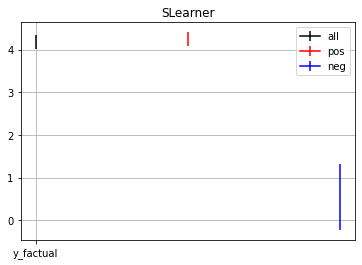

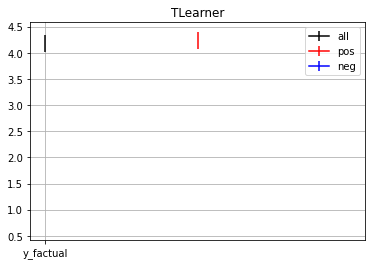

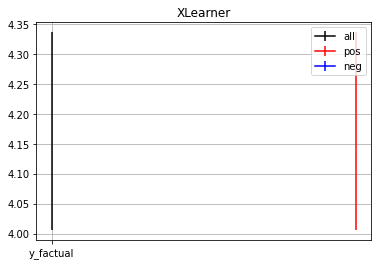

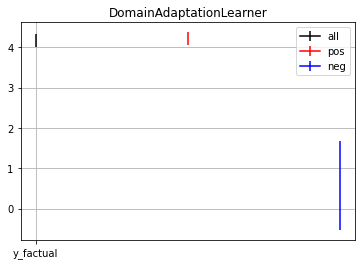

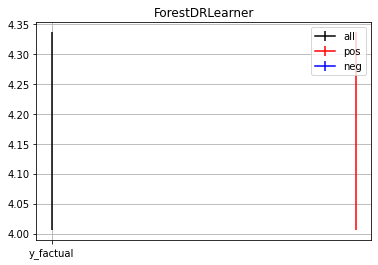

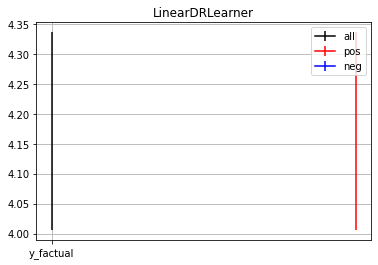

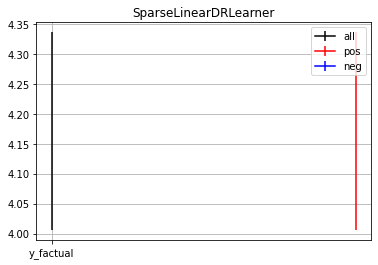

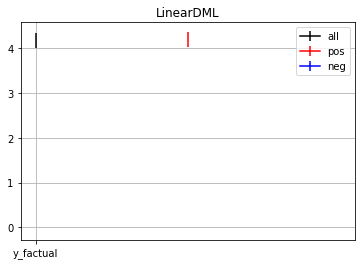

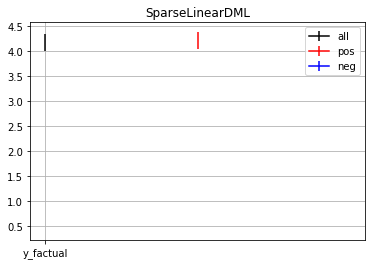

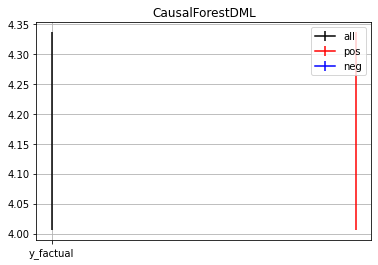

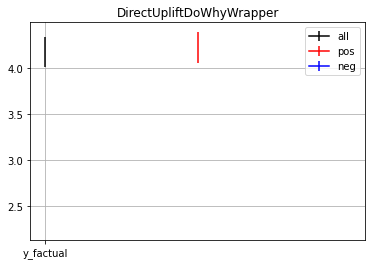

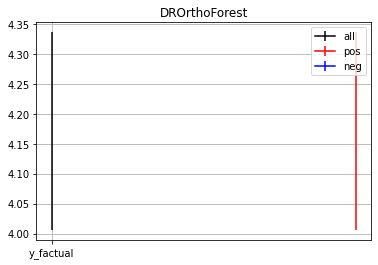

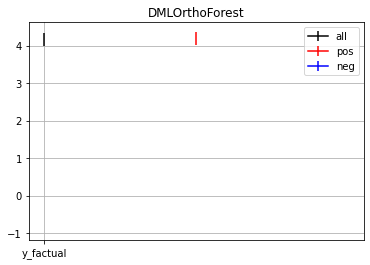

In [21]:
# plot out-of sample difference of outcomes between treated and untreated for the points where a model predicts positive vs negative impact

for my_est in [e for e in scores[targets[0]].keys() if e != 'baseline']:
    stats = []
    for outcome in targets:
        if 'test' not in scores[outcome][my_est]:
            continue
        v = scores[outcome][my_est]['test']['values']
        stats.append(group_ate(v['treated'], v[outcome], v['policy']))

    sts = pd.DataFrame(stats)
    sts


    colors = (matplotlib.colors.CSS4_COLORS['black'],
        matplotlib.colors.CSS4_COLORS['red'],
        matplotlib.colors.CSS4_COLORS['blue'])
    grp = ['all', 'pos','neg']

    for i,(g,c) in enumerate(zip(grp, colors)):
        plt.errorbar(np.array(range(len(sts))) +0.1*i, sts[f"{g}_mean"],  yerr = sts[f"{g}_std"], color=c)
    plt.legend(grp)
    plt.grid(True)
    plt.xticks(range(len(sts)), targets)
    plt.title(my_est.split('.')[-1])
    plt.show()

In [2]:
from auto_causality.utils import fit_params_wrapper, AutoML

ModuleNotFoundError: No module named 'auto_causality'